# IMPORTING LIBRARIES


In [1]:
from skimage import io
import numpy as np
import cv2
from glob import glob
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os
from keras.utils import to_categorical
import tensorflow as tf
import keras
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from tqdm import tqdm
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk
import os
import segmentation_models_3D as sm
from patchify import patchify, unpatchify
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

2024-04-08 11:52:52.949889: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 11:52:53.322092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 11:52:54.151226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=31000)]) 
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            configs  = tf.config.get_logical_device_configuration( gpu )  
            print(gpu, " :::::::::::: ", logical_gpus , " :::::: ", configs)
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')  ::::::::::::  [LogicalDevice(name='/device:GPU:0', device_type='GPU')]  ::::::  [LogicalDeviceConfiguration(memory_limit=31000, experimental_priority=None, experimental_device_ordinal=None)]
1 Physical GPUs, 1 Logical GPUs


2024-04-08 11:52:56.459993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 11:52:56.885919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 11:52:56.886030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 11:52:56.901412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 11:52:56.901509: I tensorflow/compile

In [3]:
global IMG_H
global IMG_W
global IMG_D
global NUM_CLASSES
global CLASSES
global image_h
global image_w
global num_classes
global classes
global rgb_codes
global COLORMAP
global case_names
global dataset_path
global input_shape
global dataOutputPath
image_h = 512
image_w = 512
num_classes = 31
input_shape = (image_h, image_w, 3)
batch_size = 2
lr = 1e-4
num_epochs = 7
dataset_path = '/mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/'
os.chdir(dataset_path)
input_path =dataset_path + 'set_2/'
case_names = [f"case_{num:02d}" for num in range(1, 43)]
dataOutputPath =dataset_path + 'set_4/'
imageSliceOutput = os.path.join(dataOutputPath, 'img/')
maskSliceOutput = os.path.join(dataOutputPath, 'mask/')
trainsetOutput = os.path.join(dataOutputPath, 'train/')
testsetOutput = os.path.join(dataOutputPath, 'test/')
dataset_path = '/mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/set_4'
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "data.csv")
SEED = 909
BATCH_SIZE_TRAIN = 2
BATCH_SIZE_TEST = 2
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
data_dir = '/mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/set_4/'
data_dir_train = os.path.join(data_dir, 'train/')
data_dir_train_image = os.path.join(data_dir_train, 'images/')
data_dir_train_mask = os.path.join(data_dir_train, 'masks/')
data_dir_test = os.path.join(data_dir, 'test/')
data_dir_test_image = os.path.join(data_dir_test, 'images/')
data_dir_test_mask = os.path.join(data_dir_test, 'masks/')
NUM_OF_EPOCHS = 10
LABEL_dict = {
    "background": 0,
    "A_Carotid_L": 1,
    "A_Carotid_R": 2,
    "Arytenoid": 3,
    "Bone_Mandible": 4,
    "Brainstem": 5,
    "BuccalMucosa": 6,
    "Cavity_Oral": 7,
    "Cochlea_L": 8,
    "Cochlea_R": 9,
    "Cricopharyngeus": 10,
    "Esophagus_S": 11,
    "Eye_AL": 12,
    "Eye_AR": 13,
    "Eye_PL": 14,
    "Eye_PR": 15,
    "Glnd_Lacrimal_L": 16,
    "Glnd_Lacrimal_R": 17,
    "Glnd_Submand_L": 18,
    "Glnd_Submand_R": 19,
    "Glnd_Thyroid": 20,
    "Glottis": 21,
    "Larynx_SG": 22,
    "Lips": 23,
    "OpticChiasm": 24,
    "OpticNrv_L": 25,
    "OpticNrv_R": 26,
    "Parotid_L": 27,
    "Parotid_R": 28,
    "Pituitary": 29,
    "SpinalCord": 30,
}
rgb_codes = [
    [255, 255, 255],          # Background
            [244, 214, 49],    # SpinalCord
            [216, 101, 79],    # A_Carotid_L
            [216, 101, 79],    # A_Carotid_R
            [183, 156, 220],   # Arytenoid
            [222, 198, 101],   # Bone_Mandible
            [145, 92, 109],    # Brainstem
            [178, 69, 182],    # BuccalMucosa
            [121, 39, 153],    # Cavity_Oral
            [104, 181, 63],    # Cochlea_L
            [123, 174, 91],    # Cochlea_R
            [220, 127, 211],   # Cricopharyngeus
            [174, 125, 64],    # Esophagus_S
            [127, 75, 38],     # Eye_AL
            [127, 75, 38],     # Eye_AR
            [53, 152, 174],    # Eye_PL
            [53, 152, 174],    # Eye_PR
            [86, 58, 127],     # Glnd_Lacrimal_L
            [86, 58, 127],     # Glnd_Lacrimal_R
            [222, 198, 101],   # Glnd_Submand_L
            [222, 198, 101],   # Glnd_Submand_R
            [62, 162, 114],    # Glnd_Thyroid
            [47, 210, 120],    # Glottis
            [150, 208, 243],   # Larynx_SG
            [188, 91, 95],     # Lips
            [99, 106, 24],     # OpticChiasm
            [127, 24, 70],     # OpticNrv_L
            [127, 24, 70],     # OpticNrv_R
            [31, 45, 172],     # Parotid_L
            [31, 45, 172],     # Parotid_R
            [57, 157, 110]  
]
classes = [
    "background",  
            "A_Carotid_L",
            "A_Carotid_R",
            "Arytenoid",
            "Bone_Mandible",
            "Brainstem",
            "BuccalMucosa",
            "Cavity_Oral",
            "Cochlea_L",
            "Cochlea_R",
            "Cricopharyngeus",
            "Esophagus_S",
            "Eye_AL",
            "Eye_AR",
            "Eye_PL",
            "Eye_PR",
            "Glnd_Lacrimal_L",
            "Glnd_Lacrimal_R",
            "Glnd_Submand_L",
            "Glnd_Submand_R",
            "Glnd_Thyroid",
            "Glottis",
            "Larynx_SG",
            "Lips",
            "OpticChiasm",
            "OpticNrv_L",
            "OpticNrv_R",
            "Parotid_L",
            "Parotid_R",
            "Pituitary",
            "SpinalCord"
]

In [4]:
def load_data(case_number):
    CT_volume = io.imread(input_path + f"/{case_names[case_number]}/{case_names[case_number]}_IMG_CT.nrrd")
    MR_volume = io.imread(input_path + f"/{case_names[case_number]}/{case_names[case_number]}_IMG_MR_T1.nrrd")
    mask = io.imread(input_path + f"/{case_names[case_number]}/{case_names[case_number]}_stacked_segments.seg.nrrd")
    print(f"Case number {case_number} is being processed : Mask shape = {mask.shape}  || CT shape = {CT_volume.shape} || MR shape = {MR_volume.shape}")
    return CT_volume, MR_volume, mask

In [5]:
def load_data_sitk(case_number):
    CT_volume = sitk.ReadImage(input_path + f"/{case_names[case_number]}/{case_names[case_number]}_IMG_CT.nrrd")
    MR_volume = sitk.ReadImage(input_path + f"/{case_names[case_number]}/{case_names[case_number]}_IMG_MR_T1.nrrd")
    mask = sitk.ReadImage(input_path + f"/{case_names[case_number]}/{case_names[case_number]}_stacked_segments.seg.nrrd")
    return CT_volume, MR_volume, mask

In [6]:
def normalizeImageIntensityRange(img, clip_min=0, shiftThreshold=1):
    minimg=min(img[img > 0].flatten())
    #print(f"Min value is {minimg}, Max value is {max(img.flatten())}, dtype is {img.dtype}")
    shifted_img = img.copy()  # Create a copy to avoid in-place modification
    if(minimg > shiftThreshold):  
        shifted_img = shifted_img.astype(np.int16)
        shifted_img -= minimg
        #print(f"Min value is {min(shifted_img.flatten())}, Max value is {max(shifted_img.flatten())}")
        shifted_img = np.clip(shifted_img, clip_min, None)
        #print(f"Min value is {min(shifted_img.flatten())},Max value is {max(shifted_img.flatten())}, MR SHAPE : {shifted_img.shape} ")
    return shifted_img

In [7]:
def center_crop_volumes(case_number):
    ct_image, mri_image, mask=load_data_sitk(case_number)
    #mask = sitk.Cast(sitk.RescaleIntensity(mask), sitk.sitkUInt8)
    mr_resampled = sitk.Resample(mri_image, ct_image)
    #mr_resampled = sitk.RescaleIntensity(mr_resampled, outputMinimum=0, outputMaximum=255)
    ct_array = sitk.GetArrayFromImage(ct_image)
    mri_array = sitk.GetArrayFromImage(mr_resampled)
    mask_array = sitk.GetArrayFromImage(mask)
    #scaled_mask = (mask_array / 255 * 31)  # Perform scaling
    #mask_uint8 = scaled_mask.astype(np.uint8)
    return ct_array, mri_array, mask_array

In [8]:
def is_empty_image(img):
    return np.all(img == 0) 

In [9]:
def concatenate_data(concatenated_volume, Masks, CT_volume, MR_volume, mask):
    if(np.all(Masks == 0) and np.all(concatenated_volume == 0)):
        concatenated_volume = np.concatenate((CT_volume, MR_volume), axis=0)
        Masks = np.concatenate((mask, mask), axis=0)
        #print(f"Volume shape is {concatenated_volume.shape}  ")
        return concatenated_volume, Masks
    concatenated_volume = np.concatenate((concatenated_volume, CT_volume), axis=0)
    concatenated_volume = np.concatenate((concatenated_volume, MR_volume), axis=0)
    Masks = np.concatenate((Masks, mask), axis=0)
    Masks = np.concatenate((Masks, mask), axis=0)
    #print(f"Volume shape is {concatenated_volume.shape} ")
    if(concatenated_volume.shape != Masks.shape):
        print("Concatenation error")
    return concatenated_volume, Masks

In [10]:
def class_to_dict (msk, class_counts, label_dict = LABEL_dict):
    unique_classes, counts = np.unique(msk, return_counts=True)
    for class_value, count in zip(unique_classes, counts):
        if class_value in label_dict.values():
            class_name = [key for key, value in label_dict.items() if value == class_value][0]
            class_counts[class_name] += 1
    return class_counts

In [11]:
def count_empty_masks(patches):
    total_masks = 0
    empty_masks = 0
    for i in range(patches.shape[0]):
        if np.all(patches[i] == 0):
            empty_masks += 1
        total_masks += 1
    return empty_masks, total_masks

In [12]:
def get_non_empty_images(patches, masks):
    non_empty_patches = np.empty((0, 128, 128, 128))
    non_empty_masks = np.empty((0, 128, 128, 128))
    for i in range(patches.shape[0]):
        if not np.all(patches[i] == 0):
            patch = np.expand_dims(patches[i], axis=0)
            mask = np.expand_dims(masks[i], axis=0)
            if non_empty_patches.shape == (0, 128, 128, 128) and non_empty_masks.shape == (0, 128, 128, 128):
                non_empty_patches = patch
                non_empty_masks = mask
            else:
                non_empty_patches = np.concatenate((non_empty_patches, patch), axis=0)
                non_empty_masks = np.concatenate((non_empty_patches, patch), axis=0)
            print(f"Non empty patches shape is {non_empty_patches.shape} and non empty masks shape is {non_empty_masks.shape}")
    return non_empty_patches, non_empty_masks

In [13]:
def get_non_empty_patches (patches, masks):
    #non_empty_indices = np.logical_not(np.all(patches == 0, axis=(1, 2, 3)))
    non_empty_indices = np.logical_not(np.all(masks == 0, axis=(1, 2, 3)))
    non_empty_patches = patches[non_empty_indices]
    non_empty_masks = masks[non_empty_indices]
    print(f"Number of non-empty patches: {len(non_empty_patches)}")
    return non_empty_patches, non_empty_masks

In [14]:
def load_all_data(start_case = 0, end_case = len(case_names), normalize=False, concatenate=False , target_shape = (512, 512, 512), label_dict = LABEL_dict, imageSliceOutput = imageSliceOutput, maskSliceOutput = maskSliceOutput):
    numOfSlicesCT = 0
    numOfSlicesMR = 0
    if concatenate:
        concatenated_volume = np.empty((512, 512, 512))
        Masks = np.empty((512, 512, 512))
    class_counts = {name: 0 for name in label_dict.keys()}  
    for case_number in range(start_case, end_case):
        CT_volume_old, MR_volume_old, mask_old= load_data(case_number)      
        original_CT = CT_volume_old.shape
        original_MR = MR_volume_old.shape
        CT_volume, MR_volume, mask = center_crop_volumes(case_number)  
        cropped_ct_image, cropped_mr_image, cropped_mask = CT_volume, MR_volume, mask
        if normalize:
            cropped_mr_image=normalizeImageIntensityRange(cropped_mr_image)
            #cropped_ct_image=normalizeImageIntensityRange(cropped_ct_image)
        if concatenate:
            concatenated_volume, Masks = concatenate_data(concatenated_volume, Masks, cropped_ct_image, cropped_mr_image, cropped_mask)
            # if(concatenated_volume.shape[1] > target_shape[1]):
            #     left = (concatenated_volume.shape[1] - target_shape[1]) // 2
            #     top = (concatenated_volume.shape[2] - target_shape[2]) // 2
            #     right = left + width
            #     bottom = top + height
            #     concatenated_volume = concatenated_volume[:input_shape[0]]
            #     Masks = Masks[:input_shape[0]]
        print("CT Volume Shape: ", CT_volume.shape," || MR Volume Shape: ", MR_volume.shape," || MASK Shape: ", mask.shape) 
    if concatenate:
        print(f"Concatenated volume shape is {concatenated_volume.shape} and mask shape is {Masks.shape}")        
        return concatenated_volume, Masks
    else:
        return cropped_ct_image, cropped_mr_image, cropped_mask

In [15]:
concatenated_volume, Masks = load_all_data(start_case = 0, end_case = 1, normalize=True, concatenate=True)

Case number 0 is being processed : Mask shape = (202, 1024, 1024)  || CT shape = (202, 1024, 1024) || MR shape = (83, 512, 512)
CT Volume Shape:  (202, 1024, 1024)  || MR Volume Shape:  (202, 1024, 1024)  || MASK Shape:  (202, 1024, 1024)
Case number 1 is being processed : Mask shape = (204, 1024, 1024)  || CT shape = (204, 1024, 1024) || MR shape = (144, 512, 512)
CT Volume Shape:  (204, 1024, 1024)  || MR Volume Shape:  (204, 1024, 1024)  || MASK Shape:  (204, 1024, 1024)
Concatenated volume shape is (812, 1024, 1024) and mask shape is (812, 1024, 1024)


In [16]:
# i= 600
# plt.figure(figsize=(5,5))
# plt.imshow(concatenated_volume[:,i,:])
# plt.imshow(Masks[:,i,:], cmap='jet', alpha=0.5)  # Change alpha to adjust transparency
# plt.show()

In [17]:
concatenated_volume = patchify(concatenated_volume, (128,128,128), step=128)
Masks = patchify(Masks, (128, 128, 128), step=128)
concatenated_volume = np.reshape(concatenated_volume, (-1, concatenated_volume.shape[3], concatenated_volume.shape[4], concatenated_volume.shape[5]))
Masks = np.reshape(Masks, (-1, Masks.shape[3], Masks.shape[4], Masks.shape[5]))

In [18]:
# concatenated_volume.shape, Masks.shape

In [19]:
# empty_count, total_count = count_empty_masks(concatenated_volume)
# 
# if total_count > 0:
#   empty_percentage = (empty_count / total_count) * 100
#   print(f"There are {empty_count} empty images out of {total_count} total images.")
#   print(f"This represents an empty images percentage of {empty_percentage:.2f}%.")
# else:
#   print("No image found in the specified folder.")
# 
# 
# empty_count, total_count = count_empty_masks(Masks)
# 
# if total_count > 0:
#   empty_percentage = (empty_count / total_count) * 100
#   print(f"There are {empty_count} empty masks out of {total_count} total masks.")
#   print(f"This represents an empty mask percentage of {empty_percentage:.2f}%.")
# else:
#   print("No masks found in the specified folder.")


In [20]:
non_empty_images, non_empty_masks = get_non_empty_patches(concatenated_volume, Masks)

Number of non-empty patches: 151


In [21]:
# plt.imshow(non_empty_images[1][:, 50, :])

In [22]:
# plt.imshow(non_empty_masks[1][:, 50, :])

In [23]:
# empty_count, total_count = count_empty_masks(non_empty_images)
# 
# if total_count > 0:
#   empty_percentage = (empty_count / total_count) * 100
#   print(f"There are {empty_count} empty images out of {total_count} total images.")
#   print(f"This represents an empty images percentage of {empty_percentage:.2f}%.")
# else:
#   print("No image found in the specified folder.")
# 
# 
# empty_count, total_count = count_empty_masks(non_empty_masks)
# 
# if total_count > 0:
#   empty_percentage = (empty_count / total_count) * 100
#   print(f"There are {empty_count} empty masks out of {total_count} total masks.")
#   print(f"This represents an empty mask percentage of {empty_percentage:.2f}%.")
# else:
#   print("No masks found in the specified folder.")


In [24]:
n_classes = 31

In [25]:
train_img = np.stack((non_empty_images,)*3, axis=-1)
train_mask = np.expand_dims(non_empty_masks, axis=4)


train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)

In [26]:
#Define parameters for our model.
encoder_weights = 'imagenet'
BACKBONE = 'resnet18'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 128
n_classes = 31
channels=3
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
loss_to_use = sm.losses.bce_jaccard_loss
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

2024-04-06 01:07:09.748135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 30.27GiB (32505856000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-04-06 01:07:13.606769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 27.25GiB (29255270400 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-04-06 01:07:17.160336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 24.52GiB (26329743360 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [27]:
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [28]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes,
                input_shape=(patch_size, patch_size, patch_size, channels),
                encoder_weights=encoder_weights,
                activation=activation)

In [29]:
model.compile(optimizer = optim,
              #loss=loss_to_use,
              loss="categorical_crossentropy",
              metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 64, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv3D)       (None, 64, 64, 64, 64)       5248      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv3D)       (None, 64, 64, 64, 64)       110656    ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling3D)  (None, 32, 32, 32, 64)       0         ['block1_conv2[0][0]']        
                                                                                              

In [30]:
print("Training data shape:", X_train_prep.shape)
print("Ground truth labels shape:", y_train.shape)

Training data shape: (135, 64, 64, 64, 3)
Ground truth labels shape: (135, 64, 64, 64, 31)


In [31]:
dataset_path = '/mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/set_4'
model_path = os.path.join(dataset_path ,"files_128")
model_xx = os.path.join(model_path, "model_128_.h5")
csv_path = os.path.join(dataset_path+f"/files_128", "data.csv")

In [32]:
callbacks = [
ModelCheckpoint(model_xx, verbose=1, save_best_only=True, monitor='val_iou_score'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
CSVLogger(csv_path, append=True),
EarlyStopping(monitor='val_iou_score', patience=20, restore_best_weights=False)
]

In [33]:
#Fit the model
history=model.fit(X_train_prep,
          y_train,
          batch_size=8,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prep, y_test),
          callbacks=callbacks
                  )

Epoch 1/100


2024-04-06 01:08:23.915328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-06 01:08:24.459009: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-06 01:08:24.459046: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-04-06 01:08:24.460931: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-04-06 01:12:09.252052: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x8bbbf20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-06 01:12:09.252127: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor dev

17/17 [==============================] - ETA: 0s - loss: 3.6119 - iou_score: 0.2410 - f1-score: 0.2411 
Epoch 1: val_iou_score improved from inf to 0.08101, saving model to /mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/set_4/files_64/model_64_.h5


/home/aziz0220/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 1916s 84s/step - loss: 3.6119 - iou_score: 0.2410 - f1-score: 0.2411 - val_loss: 4.3981 - val_iou_score: 0.0810 - val_f1-score: 0.0814 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 3.1530 - iou_score: 0.2657 - f1-score: 0.2657 
Epoch 2: val_iou_score did not improve from 0.08101
17/17 [==============================] - 419s 25s/step - loss: 3.1530 - iou_score: 0.2657 - f1-score: 0.2657 - val_loss: 2.7529 - val_iou_score: 0.1141 - val_f1-score: 0.1152 - lr: 1.0000e-04
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 2.6454 - iou_score: 0.4118 - f1-score: 0.4118 
Epoch 3: val_iou_score did not improve from 0.08101
17/17 [==============================] - 393s 23s/step - loss: 2.6454 - iou_score: 0.4118 - f1-score: 0.4118 - val_loss: 2.6181 - val_iou_score: 0.2609 - val_f1-score: 0.2629 - lr: 1.0000e-04
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 2.0561 - iou_score

In [34]:
data_dir = '/mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/set_4/'

In [36]:
model.save(data_dir + '3D_model_vgg16_25epoch_8batch_gpu128patch2.h5')

In [15]:
concatenated_volume, Masks = load_all_data(start_case = 0, end_case = 1, normalize=True, concatenate=True)

Case number 0 is being processed : Mask shape = (202, 1024, 1024)  || CT shape = (202, 1024, 1024) || MR shape = (83, 512, 512)
CT Volume Shape:  (202, 1024, 1024)  || MR Volume Shape:  (202, 1024, 1024)  || MASK Shape:  (202, 1024, 1024)
Concatenated volume shape is (404, 1024, 1024) and mask shape is (404, 1024, 1024)


In [16]:
from keras.models import load_model
my_model = load_model('/mnt/c/Users/benam/Downloads/HaN-Seg/HaN-Seg/set_4/files_128/model_128_.h5', compile=False)

2024-04-08 11:54:14.893761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 30.27GiB (32505856000 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-04-08 11:54:17.816059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 27.25GiB (29255270400 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-04-08 11:54:20.501724: I tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:753] failed to allocate 24.52GiB (26329743360 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [17]:
large_image = concatenated_volume
patches = patchify(large_image, (128, 128, 128), step=128)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(404, 1024, 1024)
(6, 16, 16, 64, 64, 64)


In [20]:
BACKBONE = 'vgg16'

In [21]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [22]:
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)

2024-04-08 11:55:31.502852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-08 11:55:31.699429: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-08 11:55:31.699469: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-04-08 11:55:31.700381: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 0s 13ms/step


In [23]:
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(1536, 64, 64, 64)


In [24]:
predicted_patches_reshaped = np.reshape(predicted_patches,
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(6, 16, 16, 64, 64, 64)


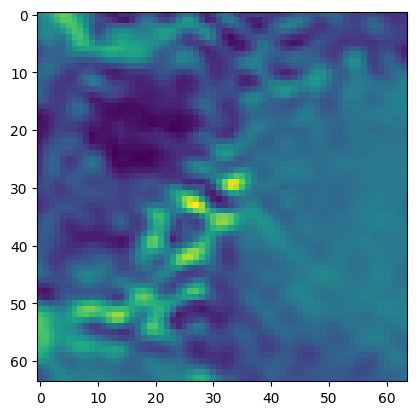

In [35]:
plt.imshow(patches[5, 7, 8, 30, :,:])

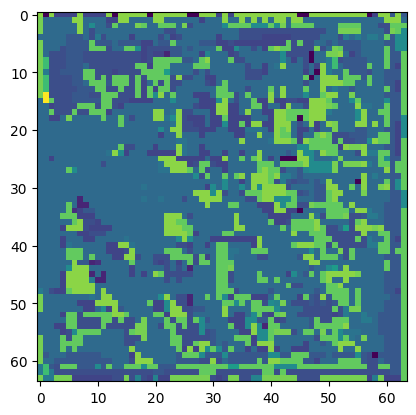

In [36]:
plt.imshow(predicted_patches_reshaped[5, 7, 8, 30, :,:])

In [25]:
large_image.shape

(404, 1024, 1024)

In [26]:
reconstructed_image = unpatchify(predicted_patches_reshaped, concatenated_volume.shape)
print(reconstructed_image.shape)

KeyboardInterrupt: 

In [ ]:
print(reconstructed_image.dtype)

In [ ]:
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

In [ ]:
from tifffile import imwrite
imwrite('3dunetpredictioncase1.tif', reconstructed_image)